<h1><center>Laboratorio 10: Interpretabilidad 🤖</center></h1>

<center><strong>MDS7202: Laboratorio de Programación Científica para Ciencia de Datos</strong></center>

### Cuerpo Docente:

- Profesor: Pablo Badilla y Ignacio Meza D.
- Auxiliar: Sebastián Tinoco
- Ayudante: Felipe Arias y Diego Cortez

### Equipo: SUPER IMPORTANTE - notebooks sin nombre no serán revisados

- Nombre de alumno 1: Ricardo Espinoza
- Nombre de alumno 2: Cristóbal Guerra


### **Link de repositorio de GitHub:** `https://github.com/cristobalg68/Labs-Espinoza-Guerra.git`

### Indice

1. [Temas a tratar](#Temas-a-tratar:)
3. [Descripcción del laboratorio](#Descripción-del-laboratorio.)
4. [Desarrollo](#Desarrollo)

## Temas a tratar

- Clasificación usando `XGBoost`.
- Métodos Agnósticos Globales de Interpretabilidad (`Partial Dependence Plot`, `Permutation Feature Importance`)
- Métodos Agnósticos Locales de Interpretabilidad (`Scoped Rules`, `SHAP`)

## Reglas:

- **Grupos de 2 personas**
- Asistencia **obligatoria** a instrucciones del lab (viernes 16.15). Luego, pueden quedarse trabajando en las salas o irse.
- **No se revisarán entregas de personas ausentes**.
- Cualquier duda fuera del horario de clases al foro. Mensajes al equipo docente serán respondidos por este medio.
- Prohibidas las copias.
- Pueden usar cualquer matrial del curso que estimen conveniente.

### Objetivos principales del laboratorio

- Generar un pipeline de clasificación con `XGBoost`.
- Implementar modelos de interpretabilidad para explicar el funcionamiento del modelo de clasificación.

El laboratorio deberá ser desarrollado sin el uso indiscriminado de iteradores nativos de python (aka "for", "while"). La idea es que aprendan a exprimir al máximo las funciones optimizadas que nos entrega `pandas`, las cuales vale mencionar, son bastante más eficientes que los iteradores nativos sobre DataFrames.

# 0. Importanción de librerias

In [ ]:
!pip install xgboost
!pip install ydata_profiling
!pip install shap
!pip install alibi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import pandas as pd
import zipfile
import matplotlib.pyplot as plt
import shap

from ydata_profiling import ProfileReport

import xgboost as xgb
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn import set_config
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import classification_report, accuracy_score, f1_score, recall_score, precision_score
from sklearn.inspection import permutation_importance

import warnings

from alibi.explainers import AnchorTabular

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 1. Problemas Clínicos del Dr. Simi

<p align="center">
  <img src="https://gantz.cl/wp-content/uploads/2020/01/79024136_2718114448239059_7240913062570491904_o.jpg" width="350">
</p>

El reconocido **Dr. Simi**, famoso vendedor de medicamentos en latinoamerica, debido a la creciente prevalencia de enfermedades crónicas, como la diabetes, decidió abrir una clínica especializada en el tratamiento de esta enfermedad en nuestro país.

La clínica del Doctor Simi se convirtió en un lugar donde los pacientes con diabetes podrían recibir atención médica integral. El personal médico estaba compuesto por especialistas en endocrinología, nutrición y enfermería, todos capacitados en el manejo de la diabetes.

Sin embargo él se ha dado cuenta que los tiempos han cambiado y gracias a las tecnologías es posible generar mejores predicciones en la diabetes conociendo el historial médico de las personas. Por esto, el doctor se ha colocado una meta de incluir modelos de machine learning dentro de sus clínicas, para ello le ha solicitado crear un modelo capaz de predecir/clasificar diabetes pero le rogó que el desarrollo del modelo tuviera un especial enfoque en la interpretabilidad de lo que hace su modelo.

Para que usted pueda entrenar el modelo, Dr. Simi le ha entregado un dataset de todos los clientes que fueron detectados con diabetes a lo largo de la historia de la clinica. Con ello, adjunta el historial médico de las personas en forma de datos tabulares para que usted pueda realizar fácilmente la clasificación.


## 1.0 Lectura de base de datos

In [ ]:
#path = '/content/drive/My Drive/Lab_10/diabetes_data.csv.zip'

In [ ]:
path = '/content/drive/Othercomputers/Mi PC/Estudios/Universidad/Semestre_2023_1/Laboratorio_de_Programación_Científica_para_Ciencia_de_Datos/Laboratorios/Lab_10/diabetes_data.csv.zip'

In [ ]:
df_zip = zipfile.ZipFile(path)
df = pd.read_csv(df_zip.open('diabetes_data.csv'), sep=",")
df.head(4)

,Age,Sex,HighChol,CholCheck,BMI,Smoker,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,GenHlth,MentHlth,PhysHlth,DiffWalk,Stroke,HighBP,Diabetes
0,4.0,1.0,0.0,1.0,26.0,0.0,0.0,1.0,0.0,1.0,0.0,3.0,5.0,30.0,0.0,0.0,1.0,0.0
1,12.0,1.0,1.0,1.0,26.0,1.0,0.0,0.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,1.0,0.0
2,13.0,1.0,0.0,1.0,26.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,10.0,0.0,0.0,0.0,0.0
3,11.0,1.0,1.0,1.0,28.0,1.0,0.0,1.0,1.0,1.0,0.0,3.0,0.0,3.0,0.0,0.0,1.0,0.0


## 1.1 EDA y preprocesamiento de datos

In [ ]:
profile = ProfileReport(df, title="EDA")
profile.to_file("eda.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
df.shape

(70692, 18)

In [ ]:
df = df.drop_duplicates()

In [ ]:
df.shape

(64020, 18)

> Únicamente se eliminaron las filas duplicadas del dataset, ya que este no presenta valores vacíos. Notar que por la naturaleza del dataset y problema, podría existir la posibilidad de que dos filas sean efectivamente idénticas, sin embargo, esta posibilidad para la cantidad de filas con las que se cuenta (70.692) es ínfima. Tras haber eliminado los duplicados, el dataset queda con 64.020 filas

# 2. Clasificación de pacientes con diabetes (0.5 pt)

<p align="center">
  <img src="https://media.tenor.com/QH--g3ZaSbsAAAAC/dr-simi-abrazo.gif" width="400">
</p>

En primer lugar, el reconocido doctor le pide entrenar un modelo de `XGBoost` utilizando como target la columna `Diabetes` del dataset `diabetes_data.csv`. Para el entrenamiento tome en cuenta **todos** los pasos necesarios para entrenar un modelo de aprendizaje supervisado vistos hasta la fecha (use `Pipeline`, `ColumnTransformer`, etc.), comente sus decisiones y los resultados obtenidos con el modelo. ¿Es acaso un buen predictor de diabetes?, ¿Qué buscan explicar las métricas utilizadas?, ¿las métricas utilizadas para medir la predictibilidad le permiten asegurar que su modelo una buena elección de las features?.

In [ ]:
set_config(transform_output="pandas")

min_max = MinMaxScaler()
minmax_columns = ['MentHlth', 'PhysHlth']

standard = StandardScaler()
standard_columns = ['Age', 'BMI']

preprocessor = ColumnTransformer(
    transformers=[('MinMaxScaler', min_max, minmax_columns),
                  ('StandardScaler', standard, standard_columns)
                  ], remainder='passthrough')

In [ ]:
Pipe1 = Pipeline([
            ('Se trasforman las columnas', preprocessor),
            ('XGBoost', xgb.XGBClassifier(n_estimators=2, max_depth=2, learning_rate=1, objective='binary:logistic'))
        ])

In [ ]:
X = df.drop(columns=['Diabetes'])
y = df['Diabetes'].astype('int')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=22)
target_names = ['DIABETES', 'NODIABETES']

In [ ]:
Pipe1.fit(X_train, y_train)
y_pred_1 = Pipe1.predict(X_test)

print(f'El accuracy es {accuracy_score(y_test, y_pred_1)}')
print(f'El precision es {precision_score(y_test, y_pred_1)}')
print(f'El recall es {recall_score(y_test, y_pred_1)}')
print(classification_report(y_test, y_pred_1, target_names=target_names))

El accuracy es 0.7166510465479538
El precision es 0.7015524158381301
El recall es 0.7992845786963434
              precision    recall  f1-score   support

    DIABETES       0.74      0.63      0.68      9142
  NODIABETES       0.70      0.80      0.75     10064

    accuracy                           0.72     19206
   macro avg       0.72      0.71      0.71     19206
weighted avg       0.72      0.72      0.71     19206



> De los resultados anteriores se nota que el modelo tiene un rendimiento aceptable, en particular:
- Accuracy = 0,72: indica que el modelo es decente a la hora de acertar en sus predicciones (positivas y negativas).
- Precisiones de aprox 0.7 por clase: indica que el modelo acierta aproximadamente el 70% de las veces que predice la clase positiva y negativa.
- Recalls de 0.63 y 0.80 para clase positiva y negativa respectivamente: indica que el modelo acierta el 63% y 80% de los datos reales para la clase positiva y negativa respectivamente.
- F1 Scores de aprox 0.7 por clase: al ser una combinación entre los precision y recall de cada clase, sirve como medida que "pondera" ambas y devuelve el rendimiento "promedio" entre ambas para cada clase.

> En conclusión, el modelo es un predictor aceptable de diabetes pero tiene mucho espacio para mejorar ya que en problemas que involucran la salud de los pacientes es necesario considerar las implicancias éticas de cometer errores en las predicciones, por lo que eventualmente sería deseable lograr resultados de recall y precision mayores a los obtenidos en esta primera iteración.

> Por último, a partir de los resultados, se podría decir que las features consideradas resultan ser útiles, pero que también se debería buscar agregar más features nuevas para mejorar el rendimiento.

# 3. Importancia de las features con XGBoost (0.5 pt)

<p align="center">
  <img src="https://media.tenor.com/5JAj5_IiagEAAAAd/dr-simi-dr-simi-dance.gif" width="400">
</p>

Para añadir el toque de interpretabilidad que Dr. Simi le pide, se le pide calcular la **importancia de las features** del modelo entrenado utilizando todos los métodos (*weight*, *cover*, *gain*) que posee xgboost usando `plot_importance`. ¿Los resultados obtenidos con los diferentes métodos son compatibles?, comente sus resultados y a que se debe la igualdad o desigualdad que ve en los resultados. Finalmente, ¿las importancias obtenidas son suficientes para obtener la interpretabilidad de un modelo que utiliza árboles? ¿Qué debilidad presenta este método?

In [ ]:
xgboost = Pipe1.named_steps['XGBoost']

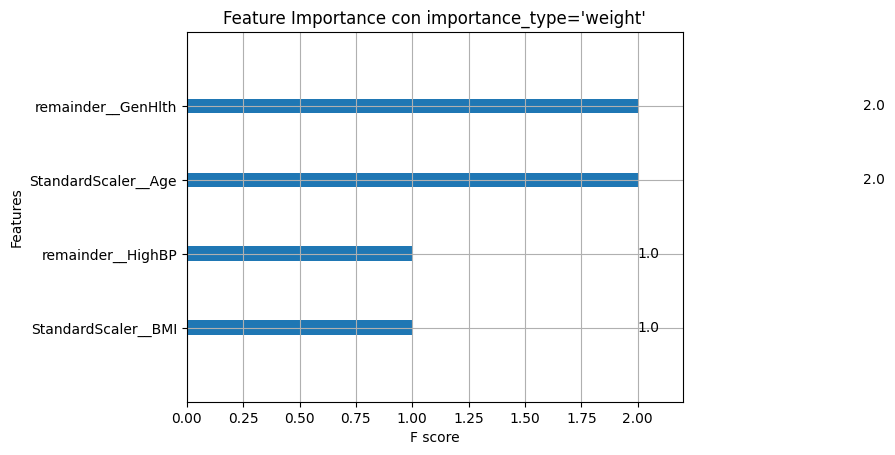

In [ ]:
xgb.plot_importance(xgboost, max_num_features=20, importance_type='weight')
plt.title("Feature Importance con importance_type='weight'")
plt.show()

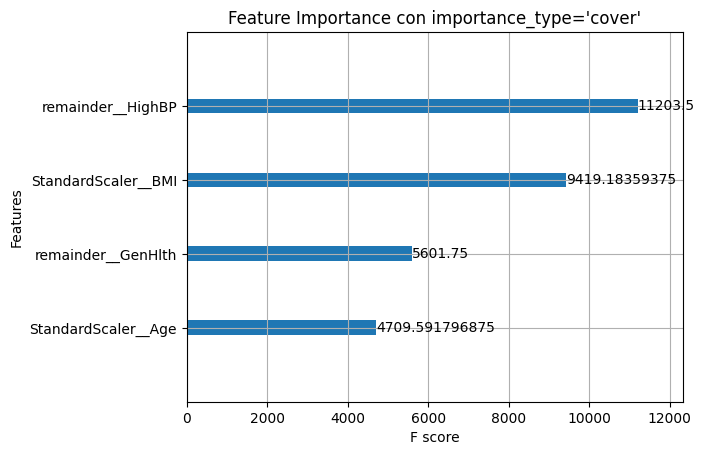

In [ ]:
xgb.plot_importance(xgboost, importance_type='cover', max_num_features=20)
plt.title("Feature Importance con importance_type='cover'")
plt.show()

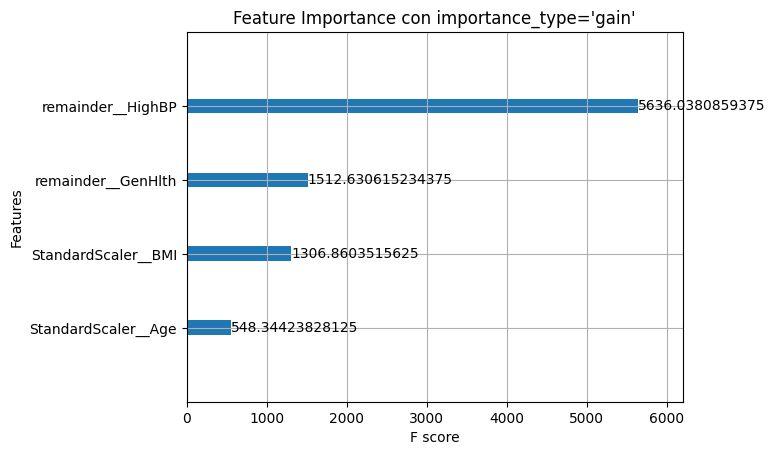

In [ ]:
xgb.plot_importance(xgboost, importance_type='gain', max_num_features=20)
plt.title("Feature Importance con importance_type='gain'")
plt.show()

In [ ]:
columnas = preprocessor.fit_transform(X)
columnas

,MinMaxScaler__MentHlth,MinMaxScaler__PhysHlth,StandardScaler__Age,StandardScaler__BMI,remainder__Sex,remainder__HighChol,remainder__CholCheck,remainder__Smoker,remainder__HeartDiseaseorAttack,remainder__PhysActivity,remainder__Fruits,remainder__Veggies,remainder__HvyAlcoholConsump,remainder__GenHlth,remainder__DiffWalk,remainder__Stroke,remainder__HighBP
0,0.166667,1.000000,-1.610595,-0.573373,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,3.0,0.0,0.0,1.0
1,0.000000,0.000000,1.185929,-0.573373,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,3.0,0.0,1.0,1.0
2,0.000000,0.333333,1.535495,-0.573373,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
3,0.000000,0.100000,0.836364,-0.298937,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,3.0,0.0,0.0,1.0
4,0.000000,0.000000,-0.212333,-0.161719,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,2.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70687,0.000000,0.000000,-0.911464,0.936025,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,4.0,0.0,0.0,0.0
70688,0.000000,0.000000,0.486798,-0.161719,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,2.0,1.0,0.0,0.0
70689,0.500000,0.000000,1.535495,-0.710591,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,5.0,1.0,0.0,1.0
70690,0.000000,0.000000,0.836364,-1.671117,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,0.0,1.0


> De los resultados de importancia de variables, se observa que para cada uno de los métodos se concluye que las mismas 4 variables resultan de relevancia [`remainder__GenHlth, remainder__HighBP, StandardScaler__Age, StandardScaler__BMI`] pero que el orden entre si cambia según el método.

# 4. Métodos Agnósticos Globales (1 pt)

<p align="center">
  <img src="https://media.tenor.com/JcRHtjVuXN8AAAAC/dr-simi-farmacias-similares.gif" width="400">
</p>

Para mitigar los problemas encontrados en la sección anterior, Dr. Simi le pide implementar un **método de permutación** que le permita observar la importancia de las features. Visualice los resultados de este método en un gráfico. Para que su modelo sea consistente, repita el proceso **30 veces** y verifique la desviación estándar de sus resultados (¿Qué señala está?). Además, responda las siguientes preguntas:


- ¿Cómo mide la importancia de las features su propuesta?
- ¿Qué features tienen un mayor impacto en la salida del modelo?. Comente las 5 primeras, ¿Tienen sentido?
- ¿Cómo cambian sus conclusiones con respecto a las features importances del punto anterior?
- Nombre y explique 3 ventajas y 3 desventajas del método implementado.

In [ ]:
result = permutation_importance(Pipe1, X_test, y_test, n_repeats=30, random_state=42)

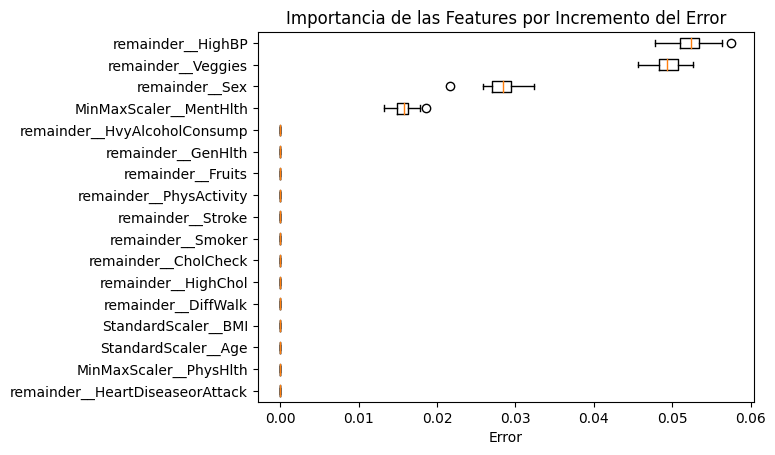

In [ ]:
perm_sorted_idx = result.importances_mean.argsort()
plt.boxplot(
    result.importances[perm_sorted_idx].T,
    vert=False,
    labels=np.array(columnas.columns)[perm_sorted_idx],
)
plt.title("Importancia de las Features por Incremento del Error")
plt.xlabel('Error')
plt.show()

> El método de permutación, como su nombre lo indica, permuta los valores de una característica y mide el impacto en el rendimiento del modelo para determinar su importancia.

> Al ordenar las importancias promedio y las características que tienen mayor importancia, y por ende, que tienen un mayor impacto en la salida del modelo, se obtiene: HighBP, Veggies, Sex, MentHlth, HvyAlcoholConsump. Ahora, si analizamos el sentido de estas variables, se puede concluir que no todas tienen sentido, pues variables como el sexo no debería influir en sí una persona tiene o no Diabetes.

> Las conclusiones cambian, ya que el método de permutación proporciona una perspectiva diferente sobre la importancia de las características. Incluso las features de mayor importancia de ambos métodos son distintas

> Ventajas:
  * Alta compresión de interpretabilidad global.
  * Considera la interacción entre características.
  * No se necesita re-entrenar el modelo.

> Desventajas:
  * Al realizar una serie de repetición el costo computación es mayor. Además, mientras mayor sea el tamaño del dataset, mayor será el costo computacional.
  * Si las features están correlacionadas, puede generar sesgos por entradas poco realistas.
  * Añadir una feature correlacionada puede decrecer la importancia de una feature asociada al separar la importancia en las dos features.

# 5. Métodos Agnósticos Locales (2 pt)

<p align="center">
  <img src="https://i.makeagif.com/media/1-27-2017/fBrzT8.mp4" width="400">
</p>

## Parte A (0.4 pt)

Alegre por saber cómo funciona el modelo de predicción a nivel general, Dr. Simi le pide ahora interpretar las predicciones de su modelo a nivel de paciente (es decir, desde un punto de vista **local**). Para esto, el ilustre farmacéutico le pide calcular los *shap values* de su modelo. ¿Qué representa cada número en su resultado? ¿Es posible atribuir un significado a la positividad/negatividad de cada valor?

In [ ]:
warnings.filterwarnings("ignore", message=".*The 'nopython' keyword.*")

In [ ]:
explainer = shap.TreeExplainer(xgboost)
shap_values = explainer(columnas)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [ ]:
shap_values.values[1,:]

array([ 0.        ,  0.        ,  0.22905591, -0.4141877 ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.34089813,  0.        ,
        0.        ,  0.53060615], dtype=float32)

> Un valor SHAP positivo podría significar que la característica aumenta la predicción del modelo, o podría significar que la característica disminuye la predicción del modelo en una cantidad menor que el valor base.

## Parte B (0.4 pt)

Usando los *shap values* calculados, grafique el **aporte** de las diferentes variables para las instancias **1**, **9** y **150**, interprete sus resultados y responda:
- ¿Qué variables afectan de manera positiva/negativa a la probabilidad de poseer diabetes?
- ¿Existe algún patrón común entre las instancias analizadas?
- ¿Es posible generalizar estas conclusiones a todo el dataset?

In [ ]:
idx = 1

shap.initjs()
shap.force_plot(explainer.expected_value,
                shap_values.values[idx,:],
                columnas.iloc[idx,:],
                link="logit")

In [ ]:
idx = 9

shap.initjs()
shap.force_plot(explainer.expected_value,
                shap_values.values[idx,:],
                columnas.iloc[idx,:],
                link="logit")

In [ ]:
idx = 150

shap.initjs()
shap.force_plot(explainer.expected_value,
                shap_values.values[idx,:],
                columnas.iloc[idx,:],
                link="logit")

> Para los idx's 1 y 150, las variables Age, GenHlth y HighBp aportan positivamente y la variable BMI aporta negativamente. Por otro lado, para el idx 9, la variable GenHlth aporta positivamente y las variables HighBP, BMI y Age aportan negativamente.

> Entre los idx's 1 y 150 se puede ver que los sentidos de aporte de las cuatro variables es el mismo. No así con el idx 9.

> De las tres instancias revisas se puede concluir que es difícil poder generalizar los resultados, pues en solo 3 instancias se pudo ver que el sentido y la magnitud de aporte de las cuatro variables es distinto.

## Parte C (0.4 pt)

Genere ahora una visualización donde se grafique el aporte de cada feature a nivel **global** e interprete sus resultados. ¿Qué diferencias existen con las conclusiones generadas a nivel de instancia?

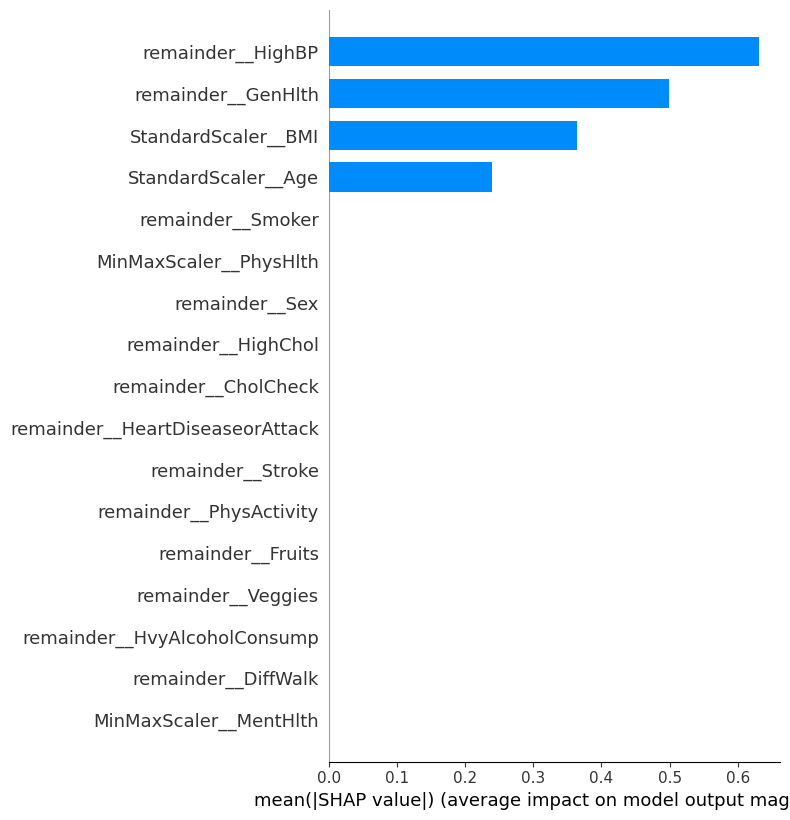

In [ ]:
shap.summary_plot(shap_values, columnas, plot_type="bar")

> Dado que en esta ocasión se muestra de forma global el nivel de importancia de las variables, es difícil poder notar alguna diferencia. Por otro lado, si es posible identificar que a nivel global se cumple lo visto en las instancias individuales, la variable HighBP es la de mayor importancia, luego le sigue GenHlth, BMI y Age.

## Parte D (0.4 pt)

Grafique ahora un *scatterplot* entre los *shap values* y las primeras 5 features con mayor impacto global (un gráfico por cada feature), coloreando cada punto por la probabilidad de tener diabetes. ¿Qué puede concluir de sus resultados?

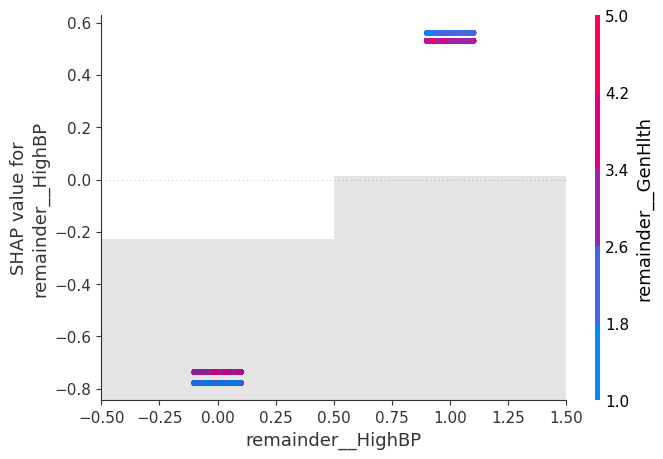

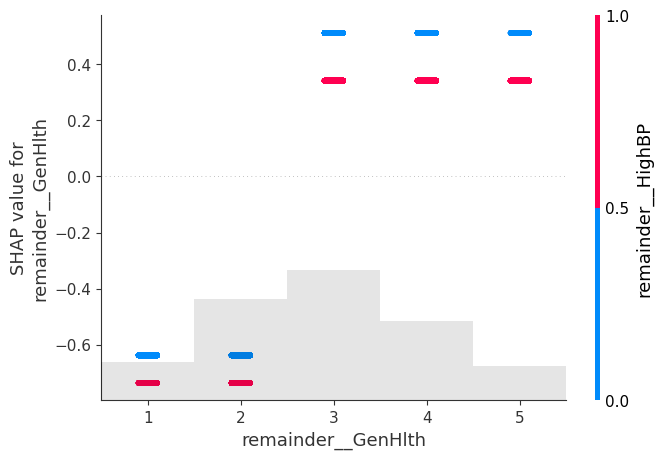

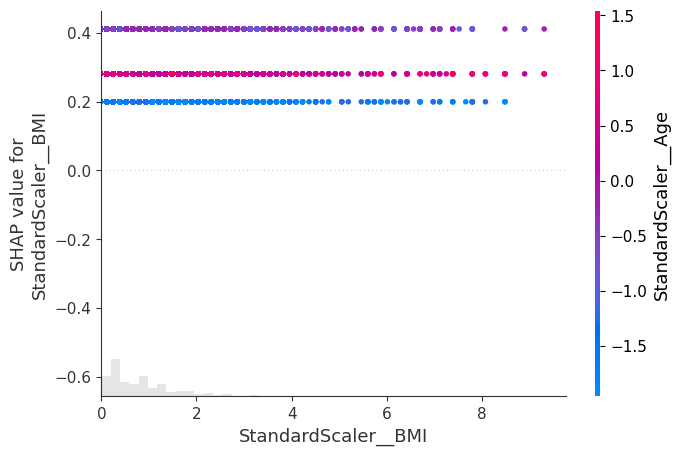

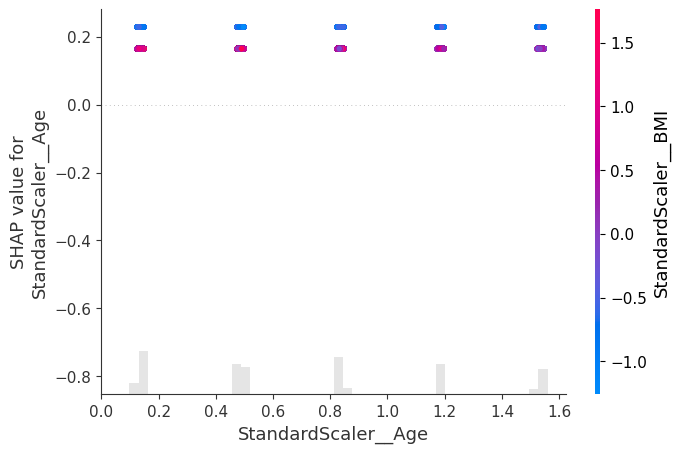

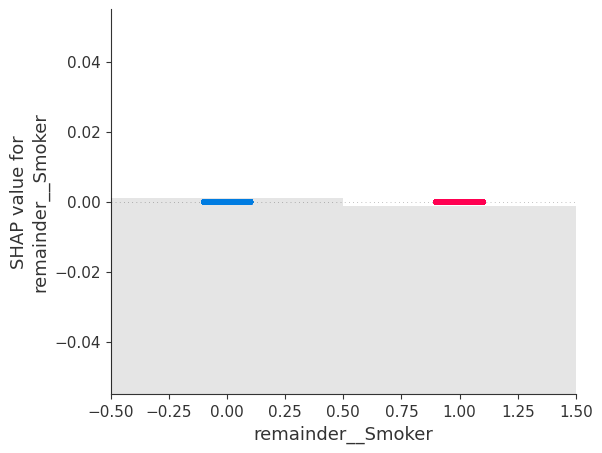

In [ ]:
shap_values_abs = np.mean(np.abs(shap_values.values), axis=0)

feature_importance_names = columnas.columns[shap_values_abs.argsort()[::-1]]

for name in feature_importance_names[:5]:
    shap.plots.scatter(shap_values[:,name],
                       color=shap_values,
                       xmin=0)

>

## Parte E (0.4 pt)

Finalmente, se le pide generar un gráfico del tipo **Partial Dependence Plot** para las mismas 5 variables con mayor impacto global usando una submuestra de **1000 observaciones**. ¿Qué relación existe entre la salida promedio del modelo y cada feature analizada? ¿Son estas conclusiones generalizables para todo el conjunto de datos?

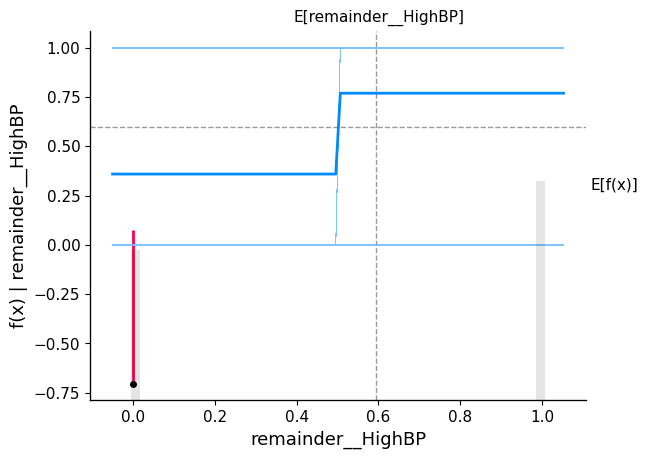

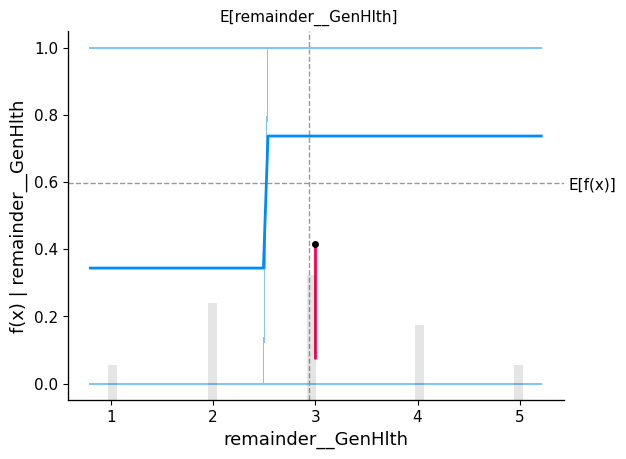

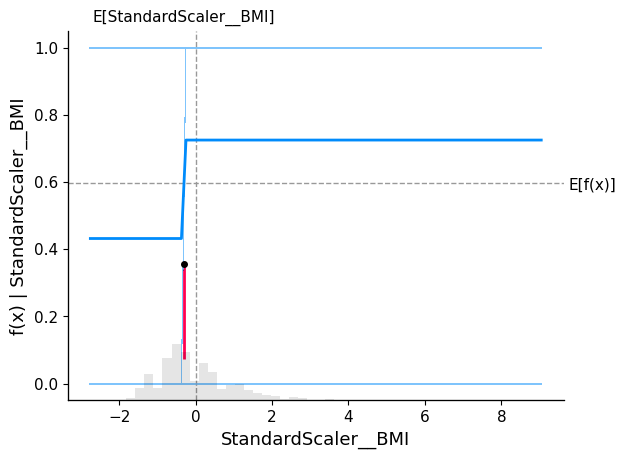

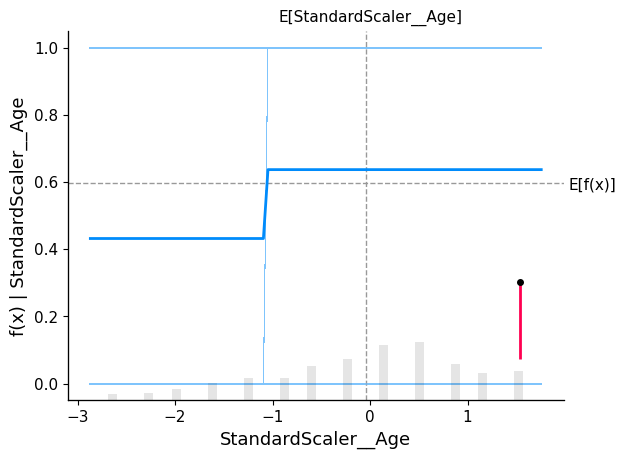

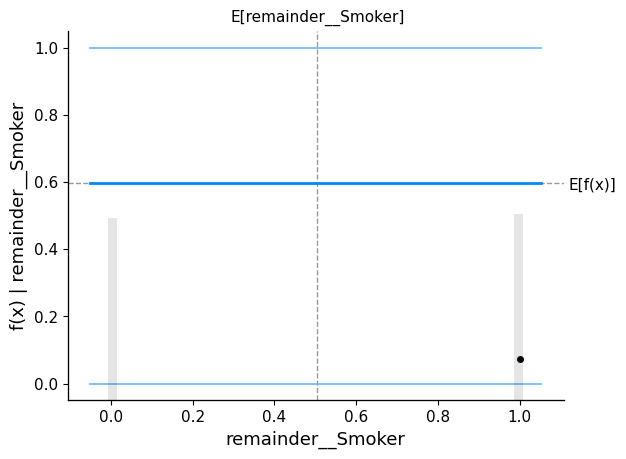

In [ ]:
X1000 = shap.utils.sample(columnas, 1000)

sample_ind = [16, 13, 3, 2, 7]
i = 0
for name in feature_importance_names[:5]:
    shap.partial_dependence_plot(
        name, xgboost.predict, X1000, model_expected_value=True,
        feature_expected_value=True, ice=True,
        shap_values=shap_values[sample_ind[i]:sample_ind[i] + 1,:]
    )
    i += 1

> Respuesta aquí

# 6. Sistema de Reglas! (1 pt)

<p align="center">
  <img src="https://media.baamboozle.com/uploads/images/125978/1638281150_1380186_gif-url.gif" width="400">
</p>

Después de todo el trabajo hecho, Dr. Simi le pide simplificar el funcionamiento de su modelo en un sistema de reglas que le permita explicar a sus clientes las predicciones que genera su modelo. En particular, Dr. Simi le pide explicar la decisión tomada para las observaciones **1000**, **3001** y **5751**. Con las reglas propuestas señale a **cuánta población** es posible explicar con estas reglas e indique la **precisión** que poseen las reglas en la totalidad de los datos. ¿Tienen sentido sus reglas propuestas para las observaciones?. Fundamente sus respuesta señalando el impacto que tienen sus reglas sobre todo el conjunto de datos.

In [ ]:
predict_fn = lambda x: xgboost.predict(x)
explainer = AnchorTabular(predict_fn, xgboost.feature_names_in_, seed=1)
explainer.fit(X_train.to_numpy())

idx = 1000
explanation = explainer.explain(X.to_numpy()[idx], threshold=0.95)
print('Prediction: ', target_names[explainer.predictor(X.to_numpy()[idx].reshape(1, -1))[0]])
print('Anchor: %s' % (' AND '.join(explanation.anchor)))
print('Precision: %.2f' % explanation.precision)
print('Coverage: %.2f' % explanation.coverage)
print('')

idx = 3001
explanation = explainer.explain(X.to_numpy()[idx], threshold=0.95)
print('Prediction: ', target_names[explainer.predictor(X.to_numpy()[idx].reshape(1, -1))[0]])
print('Anchor: %s' % (' AND '.join(explanation.anchor)))
print('Precision: %.2f' % explanation.precision)
print('Coverage: %.2f' % explanation.coverage)
print('')

idx = 5751
explanation = explainer.explain(X.to_numpy()[idx], threshold=0.95)
print('Prediction: ', target_names[explainer.predictor(X.to_numpy()[idx].reshape(1, -1))[0]])
print('Anchor: %s' % (' AND '.join(explanation.anchor)))
print('Precision: %.2f' % explanation.precision)
print('Coverage: %.2f' % explanation.coverage)

Prediction:  NODIABETES
Anchor: remainder__GenHlth > 7.00
Precision: 1.00
Coverage: 0.25

Prediction:  DIABETES
Anchor: remainder__HighBP <= 0.00 AND remainder__GenHlth <= 0.00
Precision: 1.00
Coverage: 0.26

Prediction:  DIABETES
Anchor: remainder__HighBP <= 0.00 AND remainder__GenHlth <= 0.00
Precision: 1.00
Coverage: 0.26


> Para la observación 1000, la cobertura es del 25%, lo que significa que el anchor puede explicar el 25% de las predicciones del modelo para otros puntos. Para las observaciones 3001 y 5751 la cobertura es del 26%. Por otro lado, la precisión del anchor es del 100%, lo que indica que el anchor explica correctamente todos los puntos.

> Las reglas propuestas parecen tener sentido, pues estas calzan con el previo análisis realizado con SHAP values.

# Retrospectiva... (1 pt)

En base a los diferentes métodos que implementa y ha comentado en este laboratorio, comente qué métodos le permiten entregar mejores conclusiones para la tarea de clasificación de diabetes. Por otro lado, ¿qué métodos son más útiles para el problema del doctor Simi, métodos agnosticos locales o globales?

> De todos los métodos utilizados para poder entender la importancia de características en un modelo, el que creemos que resulto de mayor utilidad fue el SHAP values, pues este permite determinar tanto de forma local como global la importancia de las características. Algo que resulta sumamente interesante fue conocer el aporte de cada característica de manera local, pues nunca antes se había revisado. Además, el nivel de detalles que se puede obtener con SHAP values es sumamente valioso, pues permite estudiar la clasificación desde distintos focos.

> El segundo método que resulto de interés fue el método de permutación, pues este trae sustanciales ventajas a la hora de determinar la importancia de características.

> Por último, luego de analizar los resultados y el objetivo del Doctor Simi, se puede concluir que los métodos agnósticos locales deberían ser los más indicados para la tarea de Doctor Simi, pues permite estudiar de manera local un determinado paciente, cosa que está en línea con la atención integral que Doctor Simi le quiere brindar a sus pacientes.

# Conclusión
Eso ha sido todo para el lab de hoy, recuerden que el laboratorio tiene un plazo de entrega de una semana. Cualquier duda del laboratorio, no duden en contactarnos por mail o U-cursos.

![Gracias Totales!](https://media.tenor.com/ctnq4bhZE3gAAAAC/drsimi-simi.gif)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=87110296-876e-426f-b91d-aaf681223468' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>